In [1]:
import zenflow as zf

import numpy as np
print("Numpy version", np.__version__)
np.random.seed(seed=369)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
sns.set_style('whitegrid')

Numpy version 1.16.4


y = [0] 	 x = [-0.96082396  0.22287371]
y = [1] 	 x = [ 1.46115081 -0.40519777]
y = [1] 	 x = [ 1.578066   -0.23241627]
y = [0] 	 x = [1.05491563 0.14992138]
y = [1] 	 x = [ 1.4932458  -0.39834706]
y = [0] 	 x = [0.47443626 0.90911671]


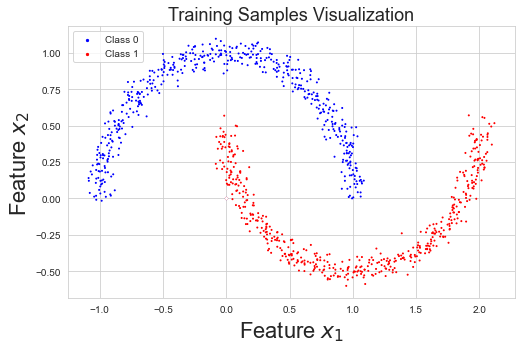

In [2]:
""" synthesis some training data """

data = make_moons(n_samples=1000, shuffle=True, noise=0.05, random_state=None) # Gaussian noise std-dev = 0.05
X = data[0]
Y = np.reshape(data[1], [len(data[1]), 1])

# display first 5 samples
i = 0
for x,y in zip(X,Y):
    print('y =', y, '\t x =', x)
    i+=1
    if i>5:
        break

# Visualize 
color_book = np.array(['blue', 'red']) # blue for class 0, red for class 1

plt.figure(figsize=(8, 5))
plt.scatter(0,0,c='blue',label='Class 0',s=5) # legend for blue dots
plt.scatter(0,0,c='red',label='Class 1',s=5)  # legend for red dots
plt.scatter(0,0,c='white',s=5) # to "erase" the legend dummy dot
plt.scatter(X[:,0], X[:,1], c=color_book[np.reshape(Y, [Y.shape[0]])], s=1)
plt.legend()

plt.xlabel('Feature $x_1$', fontsize=22)
plt.ylabel('Feature $x_2$', fontsize=22)

plt.title('Training Samples Visualization', fontsize=18)
plt.legend(loc=2)
plt.show()

# Mean Squared Error Loss

In [3]:
""" Build the neural network model """

model = zf.sequential(loss_function=zf.mean_squared_loss)

# hidden layers
fc1 = zf.dense_layer(in_dim=2, 
                     out_dim=16, 
                     activation=zf.relu, 
                     initialize='random_uniform')
fc2 = zf.dense_layer(in_dim=16, 
                     out_dim=32, 
                     activation=zf.relu, 
                     initialize='random_uniform')

# output layer
output_layer = zf.dense_layer(in_dim=32, 
                     out_dim=1, 
                     activation=zf.sigmoid, 
                     initialize='random_uniform')

# add layers to the model
model.add_layer(fc1)
model.add_layer(fc2)
model.add_layer(output_layer)

# summarize model
model.summary()

Input dimension: [?, 2]
-----------------------------------------------------
Dense layer 0	 shape: [2, 16]	 activation: relu
Dense layer 1	 shape: [16, 32]	 activation: relu
Dense layer 2	 shape: [32, 1]	 activation: sigmoid
-----------------------------------------------------
Output dimension: [?, 1]
Loss function: mean_squared_loss
Number of parameters: 576


epoch  0  loss  0.08272486596363259
epoch  10  loss  0.04012365934192591
epoch  20  loss  0.036845060275972105
epoch  30  loss  0.0354436600584661
epoch  40  loss  0.03472174583223025
epoch  50  loss  0.034209164257519575
epoch  60  loss  0.03381960979625525
epoch  70  loss  0.03351727378864652
epoch  80  loss  0.03326867753149763
epoch  90  loss  0.033071139990758426
epoch  100  loss  0.03290633658717705
epoch  110  loss  0.03276568718445698
epoch  120  loss  0.032640872323385015
epoch  130  loss  0.032529822450441476
epoch  140  loss  0.03243773263524453
epoch  150  loss  0.03235455269596414
epoch  160  loss  0.03227681308342622
epoch  170  loss  0.032197599538606694
epoch  180  loss  0.03211875247951238
epoch  190  loss  0.03205312840570676
Train accuracy:  0.88


Text(0, 0.5, 'Loss')

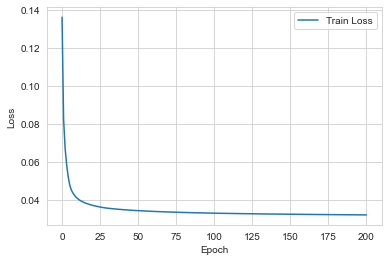

In [4]:
EPOCHS = 200 # total epochs
LR = 1e-3 # learning rate

""" optimize the weight (w) """
hist = [model.model_loss(X, Y)] # track loss values
for epoch in range(EPOCHS):
    model.auto_grad(X, Y)
    model.update_step(learning_rate=LR)
    loss = model.model_loss(X, Y)
    if epoch % 10 == 0:
        print('epoch ', epoch, ' loss ', loss)
    hist.append(loss)
    
# compute accuracy
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()
Y_pred = model.predict(X, return_score=False)
print("Train accuracy: ", accuracy(Y_pred, Y))


# plot training loss curve
plt.plot([i for i in range(len(hist))], [h for h in hist], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [10]:
""" Save and load model """
model.save('saved_model.npy')

model2 = zf.sequential(loss_function=zf.mean_squared_loss)
model2.load('saved_model.npy')
model2.summary()


Input dimension: [?, 2]
-----------------------------------------------------
Dense layer 0	 shape: [2, 16]	 activation: relu
Dense layer 1	 shape: [16, 32]	 activation: relu
Dense layer 2	 shape: [32, 1]	 activation: sigmoid
-----------------------------------------------------
Output dimension: [?, 1]
Loss function: mean_squared_loss
Number of parameters: 576


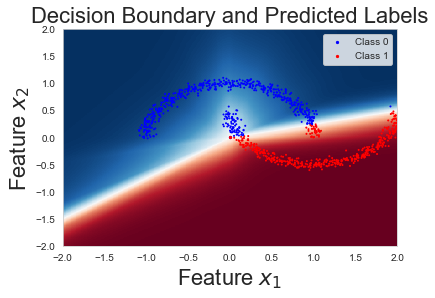

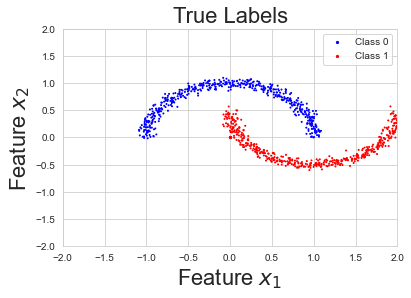

In [7]:
""" Visualize Decision Boundary """

x_1 = np.linspace(-2, 2, num=400)
x_2 = np.linspace(-2, 2, num=400)
X_prob = []
for i in range(len(x_1)):
    for j in range(len(x_2)):
        X_prob.append([x_1[j], x_2[i]])
X_prob = np.array(X_prob)
Y_prob = model.predict(X_prob, return_score=True)
decision_map = np.zeros([len(x_1),len(x_2)])
for i in range(len(x_1)):
    for j in range(len(x_2)):
        decision_map[i,j] = Y_prob[i*len(x_1)+j]

# generate 2 2d grids for the x & y bounds
x, y = np.meshgrid(x_2, x_1)
z = -(decision_map-0.5)*2
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
Y_PRED = model.predict(X, return_score=False)
plt.scatter(0,0,c='blue',label='Class 0',s=5) # legend for blue dots
plt.scatter(0,0,c='red',label='Class 1',s=5)  # legend for red dots
plt.scatter(X[:,0], X[:,1], c=color_book[np.reshape(Y_PRED, [Y_PRED.shape[0]])], s=1)
plt.legend()
plt.xlabel('Feature $x_1$', fontsize=22)
plt.ylabel('Feature $x_2$', fontsize=22)
plt.title('Decision Boundary and Predicted Labels', fontsize=22)
plt.show()

plt.scatter(0,0,c='blue',label='Class 0',s=5) # legend for blue dots
plt.scatter(0,0,c='red',label='Class 1',s=5)  # legend for red dots
plt.scatter(X[:,0], X[:,1], c=color_book[np.reshape(Y, [Y.shape[0]])], s=1)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()
plt.xlabel('Feature $x_1$', fontsize=22)
plt.ylabel('Feature $x_2$', fontsize=22)
plt.title('True Labels', fontsize=22)
plt.show()


# Binary Cross-Entropy Loss

In [16]:
""" Build the neural network model """

model = zf.sequential(loss_function=zf.mean_squared_loss)

# hidden layers
fc1 = zf.dense_layer(in_dim=2, 
                     out_dim=16, 
                     activation=zf.sin, 
                     initialize='random_uniform')
fc2 = zf.dense_layer(in_dim=16, 
                     out_dim=32, 
                     activation=zf.sin, 
                     initialize='random_uniform')
fc3 = zf.dense_layer(in_dim=32, 
                     out_dim=32, 
                     activation=zf.sin, 
                     initialize='random_uniform')

# output layer
output_layer = zf.dense_layer(in_dim=32, 
                     out_dim=1, 
                     activation=zf.sigmoid, 
                     initialize='random_uniform')

# add layers to the model
model.add_layer(fc1)
model.add_layer(fc2)
model.add_layer(fc3)
model.add_layer(output_layer)

# summarize model
model.summary()

Input dimension: [?, 2]
-----------------------------------------------------
Dense layer 0	 shape: [2, 16]	 activation: sin
Dense layer 1	 shape: [16, 32]	 activation: sin
Dense layer 2	 shape: [32, 32]	 activation: sin
Dense layer 3	 shape: [32, 1]	 activation: sigmoid
-----------------------------------------------------
Output dimension: [?, 1]
Loss function: mean_squared_loss
Number of parameters: 1,600


epoch  0  loss  0.029844281332415373
epoch  10  loss  0.005681470643458028
epoch  20  loss  0.004029866988890272
epoch  30  loss  0.0033445819677070067
epoch  40  loss  0.002940636009618979
epoch  50  loss  0.0026666518356899182
epoch  60  loss  0.0024658386305630247
epoch  70  loss  0.002310984247362454
epoch  80  loss  0.00218714777423615
epoch  90  loss  0.002085363358834381
epoch  100  loss  0.001999893591832726
epoch  110  loss  0.0019268811796908727
epoch  120  loss  0.001863628546730535
epoch  130  loss  0.0018081871316190119
epoch  140  loss  0.0017591107759093057
epoch  150  loss  0.0017153011835656547
epoch  160  loss  0.0016759075369309343
epoch  170  loss  0.0016402592582949495
epoch  180  loss  0.0016078197591031461
epoch  190  loss  0.0015781538760428328
Train accuracy:  0.997


Text(0, 0.5, 'Loss')

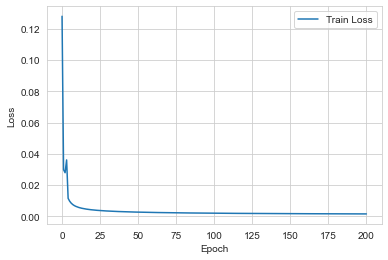

In [17]:
EPOCHS = 200 # total epochs
LR = 1e-3 # learning rate

""" optimize the weight (w) """
hist = [model.model_loss(X, Y)] # track loss values
for epoch in range(EPOCHS):
    model.auto_grad(X, Y)
    model.update_step(learning_rate=LR)
    loss = model.model_loss(X, Y)
    if epoch % 10 == 0:
        print('epoch ', epoch, ' loss ', loss)
    hist.append(loss)
    
# compute accuracy
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()
Y_pred = model.predict(X, return_score=False)
print("Train accuracy: ", accuracy(Y_pred, Y))


# plot training loss curve
plt.plot([i for i in range(len(hist))], [h for h in hist], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

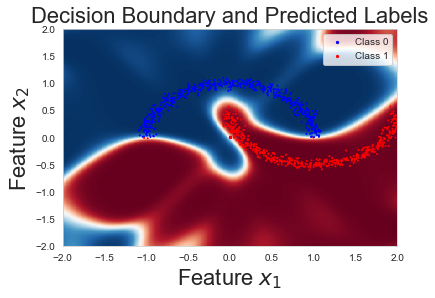

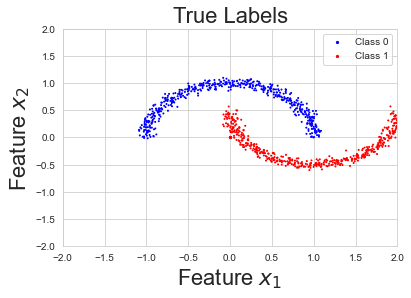

In [18]:
""" Visualize Decision Boundary """

x_1 = np.linspace(-2, 2, num=400)
x_2 = np.linspace(-2, 2, num=400)
X_prob = []
for i in range(len(x_1)):
    for j in range(len(x_2)):
        X_prob.append([x_1[j], x_2[i]])
X_prob = np.array(X_prob)
Y_prob = model.predict(X_prob, return_score=True)
decision_map = np.zeros([len(x_1),len(x_2)])
for i in range(len(x_1)):
    for j in range(len(x_2)):
        decision_map[i,j] = Y_prob[i*len(x_1)+j]

# generate 2 2d grids for the x & y bounds
x, y = np.meshgrid(x_2, x_1)
z = -(decision_map-0.5)*2
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
Y_PRED = model.predict(X, return_score=False)
plt.scatter(0,0,c='blue',label='Class 0',s=5) # legend for blue dots
plt.scatter(0,0,c='red',label='Class 1',s=5)  # legend for red dots
plt.scatter(X[:,0], X[:,1], c=color_book[np.reshape(Y_PRED, [Y_PRED.shape[0]])], s=1)
plt.legend()
plt.xlabel('Feature $x_1$', fontsize=22)
plt.ylabel('Feature $x_2$', fontsize=22)
plt.title('Decision Boundary and Predicted Labels', fontsize=22)
plt.show()

plt.scatter(0,0,c='blue',label='Class 0',s=5) # legend for blue dots
plt.scatter(0,0,c='red',label='Class 1',s=5)  # legend for red dots
plt.scatter(X[:,0], X[:,1], c=color_book[np.reshape(Y, [Y.shape[0]])], s=1)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()
plt.xlabel('Feature $x_1$', fontsize=22)
plt.ylabel('Feature $x_2$', fontsize=22)
plt.title('True Labels', fontsize=22)
plt.show()
